# Model Selection

Objective: Build and compare models for 3-gameweek forecasting while
          addressing the 61% zero-point distribution problem.

Model Architecture:
1. Naive Regression (Baseline)
2. Filtered Regression (Train only on playing time)
3. Two-Stage Model (Classification + Regression)

Mathematical Foundation:
For zero-inflated data, the expected value decomposes as:

E[Y] = P(Y > 0) × E[Y | Y > 0]

Two-stage approach models these components separately for better accuracy.

## Setup & Configuration


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import lightgbm as lgb

sns.set_style('darkgrid')

# Paths
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FEATURES_FILE = PROCESSED_DIR / "fpl_features_engineered.csv"

# Load
df = pd.read_csv(FEATURES_FILE)
print(f"Loaded: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loaded: (93666, 151)
Memory: 144.2 MB


## 1. Feature Selection

Select features for modeling, excluding:
- Target variables
- IDs and metadata
- High-cardinality strings

In [56]:
# ============================================================================
# 1. CREATE EFFICIENCY METRICS (Price/Points)
# ============================================================================
# Deflate "Value": Who generates the most output per £?
df['roi_roll_5'] = (df['total_points_roll_mean_5'] / df['value']) * 10
df['roi_roll_3'] = (df['total_points_roll_mean_3'] / df['value']) * 10

# ============================================================================
# 2. DEFINE THE "BALANCED SCOUT" FEATURE SET
# ============================================================================
balanced_features = [
    # --- 1. Nailedness (Can't score if you don't play) ---
    'minutes_roll_mean_3', 'minutes_roll_mean_5',
    'starts', 'is_starter',
    
    # --- 2. Recent Form (Output) ---
    'total_points_roll_mean_3', 'total_points_roll_mean_5',
    'total_points_roll_max_3',   # Ceiling potential (explosiveness)
    'goals_scored_roll_mean_5', 'assists_roll_mean_5',
    'bonus_roll_mean_5',         # Bonus magnet?
    
    # --- 3. The "Truth" (Underlying Data) ---
    # We prefer 5-game rolling averages for stability
    'expected_goals_roll_mean_5',
    'expected_assists_roll_mean_5',
    'expected_goal_involvements_roll_mean_5',
    'goals_vs_xg',               # Regression to the mean indicator
    
    # --- 4. Activity/Aggression (ICT) ---
    'ict_index_roll_mean_5',
    'influence_roll_mean_5',     # How involved?
    'creativity_roll_mean_5',    # Chance creation
    'threat_roll_mean_5',        # Goal threat
    
    # --- 5. Momentum (The Derivative) ---
    'points_acceleration',       # Is form improving or declining?
    'points_momentum_2gw',
    
    # --- 6. Context ---
    'was_home',
    'position_encoded',
    'opponent_team',             # Team difficulty (ID) is useful if consistent
    
    # --- 7. Efficiency (New) ---
    'roi_roll_3', 'roi_roll_5'
]

# ============================================================================
# 3. APPLY SELECTION
# ============================================================================
# Filter only existing columns
feature_cols = [c for c in balanced_features if c in df.columns]

print("Forensic Re-Calibration Complete:")

print(f"  Final Feature Count: {len(feature_cols)}")

Forensic Re-Calibration Complete:
  Final Feature Count: 21


## 2. Temporal Train-Validation-Test Split

In [57]:
def create_temporal_split(df):
    """
    Splits data maintaining strict temporal order.
    
    Train: 2021-22, 2022-23, 2023-24
    Validation: 2024-25 (GW 15+)  # CHANGED: was 20+
    Test: 2025-26 (GW 1-12)  # CHANGED: exclude last 3 GWs
    
    Returns
    -------
    tuple
        (train_df, val_df, test_df)
    """
    train_mask = df['season'].isin(['2021-22', '2022-23', '2023-24'])
    val_mask = (df['season'] == '2024-25') & (df['GW'] >= 15)  # More data
    test_mask = (df['season'] == '2025-26') & (df['GW'] <= 12)  # Leave room for targets
    
    train_df = df[train_mask].copy()
    val_df = df[val_mask].copy()
    test_df = df[test_mask].copy()
    
    print("Temporal Split:")
    print(f"  Train: {len(train_df):,} observations ({train_df['season'].unique()})")
    print(f"  Val:   {len(val_df):,} observations ({val_df['season'].unique()})")
    print(f"  Test:  {len(test_df):,} observations ({test_df['season'].unique()})")
    
    return train_df, val_df, test_df

In [58]:
train_df, val_df, test_df = create_temporal_split(df)

# Analyze zero-inflation by split
print("\nZero-Point Distribution:")
for name, data in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    zero_pct = (data['total_points'] == 0).sum() / len(data) * 100
    print(f"  {name}: {zero_pct:.1f}% zeros")

Temporal Split:
  Train: 68,398 observations (['2021-22' '2022-23' '2023-24'])
  Val:   4,881 observations (['2024-25'])
  Test:  8,818 observations (['2025-26'])

Zero-Point Distribution:
  Train: 60.5% zeros
  Val: 59.7% zeros
  Test: 60.1% zeros


## 3. Create Multi-Horizon Targets

In [59]:
def create_targets(df, horizons=[1, 2, 3]):
    """
    Creates target variables for each forecast horizon.
    Also creates binary classification target (will_play).
    
    Returns
    -------
    pd.DataFrame
        DataFrame with target_h1, target_h2, target_h3, will_play_h1, etc.
    """
    df = df.sort_values(['element', 'season', 'GW']).copy()
    
    for h in horizons:
        # Regression target (points)
        df[f'target_h{h}'] = df.groupby('element')['total_points'].shift(-h)
        
        # Classification target (will play?)
        df[f'will_play_h{h}'] = (df.groupby('element')['minutes'].shift(-h) > 0).astype(int)
    
    # Remove rows without targets (last 3 GWs per player)
    df = df.dropna(subset=[f'target_h{h}' for h in horizons])
    
    print(f"Created targets for horizons: {horizons}")
    print(f"Final observations: {len(df):,}")
    
    return df

In [60]:
train_df = create_targets(train_df)
val_df = create_targets(val_df)
test_df = create_targets(test_df)

Created targets for horizons: [1, 2, 3]
Final observations: 65,911
Created targets for horizons: [1, 2, 3]
Final observations: 2,737
Created targets for horizons: [1, 2, 3]
Final observations: 6,564


## 4. Prepare Feature Matrices

In [61]:
def prepare_features(df, feature_cols):
    """
    Prepares feature matrix with missing value handling.
    
    Returns
    -------
    np.ndarray
        Feature matrix
    """
    X = df[feature_cols].copy()
    
    # Encode categorical first (before filling NaN)
    if 'position' in X.columns:
        X['position'] = X['position'].map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})
    
    if 'was_home' in X.columns:
        X['was_home'] = X['was_home'].fillna(0).astype(int)  # Fill NaN before converting
    
    # Fill remaining missing values with median
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Final safety: fill any remaining NaN with 0
    X = X.fillna(0)
    
    return X.values

In [62]:
# Prepare feature matrices
X_train = prepare_features(train_df, feature_cols)
X_val = prepare_features(val_df, feature_cols)
X_test = prepare_features(test_df, feature_cols)

print("Feature matrix shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

Feature matrix shapes:
  Train: (65911, 21)
  Val:   (2737, 21)
  Test:  (6564, 21)


C:\Users\kadmi\AppData\Local\Temp\ipykernel_14956\2702608609.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['was_home'] = X['was_home'].fillna(0).astype(int)  # Fill NaN before converting
C:\Users\kadmi\AppData\Local\Temp\ipykernel_14956\2702608609.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['was_home'] = X['was_home'].fillna(0).astype(int)  # Fill NaN before converting


## 5. Approach 1: Naive Regression (Baseline)

Train on all data, including zeros.

In [63]:
def train_naive_regression(X_train, y_train, X_val, y_val, horizon):
    """
    Trains standard LightGBM regressor on all data.
    
    Returns
    -------
    tuple
        (model, val_mae, val_rmse, predictions)
    """
    # LightGBM parameters (moderate to avoid overfitting)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    return model, mae, rmse, r2, y_pred

In [64]:
print("="*70)
print("APPROACH 1: NAIVE REGRESSION")
print("="*70)

naive_results = {}

for h in [1, 2, 3]:
    print(f"\nHorizon {h}:")
    
    y_train = train_df[f'target_h{h}'].values
    y_val = val_df[f'target_h{h}'].values
    
    model, mae, rmse, r2, y_pred = train_naive_regression(X_train, y_train, X_val, y_val, h)
    
    print(f"  MAE:  {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²:   {r2:.3f}")
    
    naive_results[h] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

APPROACH 1: NAIVE REGRESSION

Horizon 1:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's l1: 1.10402
  MAE:  1.104
  RMSE: 2.023
  R²:   0.302

Horizon 2:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's l1: 1.14915
  MAE:  1.149
  RMSE: 2.018
  R²:   0.264

Horizon 3:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's l1: 1.14109
  MAE:  1.141
  RMSE: 1.976
  R²:   0.256


## 6. Approach 2: Filtered Regression

rain only on observations where player actually played (minutes > 0).
Then apply to all validation data.


In [65]:
def train_filtered_regression(train_df, X_train, y_train, X_val, y_val, horizon):
    """
    Trains on playing-time observations only.
    
    Strategy:
    - Filter training data to minutes > 0
    - Train regressor on this subset
    - Predict on full validation set (including non-players)
    
    Returns
    -------
    tuple
        (model, val_mae, val_rmse, predictions)
    """
    # Filter to playing time
    playing_mask = train_df['minutes'] > 0
    X_train_playing = X_train[playing_mask]
    y_train_playing = y_train[playing_mask]
    
    print(f"  Training on {len(y_train_playing):,} / {len(y_train):,} observations ({len(y_train_playing)/len(y_train)*100:.1f}% playing)")
    
    # Train model
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    train_data = lgb.Dataset(X_train_playing, label=y_train_playing)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Predict on full validation (including non-players)
    y_pred = model.predict(X_val)
    
    # Clip negative predictions to 0
    y_pred = np.maximum(y_pred, 0)
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    return model, mae, rmse, r2, y_pred


In [66]:
print("="*70)
print("APPROACH 2: FILTERED REGRESSION")
print("="*70)

filtered_results = {}

for h in [1, 2, 3]:
    print(f"\nHorizon {h}:")
    
    y_train = train_df[f'target_h{h}'].values
    y_val = val_df[f'target_h{h}'].values
    
    model, mae, rmse, r2, y_pred = train_filtered_regression(train_df, X_train, y_train, X_val, y_val, h)
    
    print(f"  MAE:  {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²:   {r2:.3f}")
    
    filtered_results[h] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

APPROACH 2: FILTERED REGRESSION

Horizon 1:
  Training on 27,598 / 65,911 observations (41.9% playing)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's l1: 1.55374
  MAE:  1.554
  RMSE: 2.154
  R²:   0.209

Horizon 2:
  Training on 27,598 / 65,911 observations (41.9% playing)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 1.57362
  MAE:  1.574
  RMSE: 2.152
  R²:   0.163

Horizon 3:
  Training on 27,598 / 65,911 observations (41.9% playing)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l1: 1.53721
  MAE:  1.537
  RMSE: 2.104
  R²:   0.157


## 7. Approach 3: Two-Stage Model 


Mathematical decomposition:

*E[points] = P(minutes > 0) × E[points | minutes > 0]*

- Stage 1: Classifier predicts P(will play)
- Stage 2: Regressor predicts E[points | playing]
- Final: Ensemble both predictions

In [67]:
def train_two_stage_model(train_df, X_train, X_val, y_train, y_val, y_train_binary, y_val_binary, horizon):
    """
    Two-stage model: Classification + Regression.
    
    Stage 1: Binary classifier for P(minutes > 0)
    Stage 2: Regressor for E[points | minutes > 0]
    Ensemble: final_pred = prob_playing × points_if_playing
    
    Returns
    -------
    tuple
        (classifier, regressor, val_mae, val_rmse, predictions)
    """
    print("  Stage 1: Training classifier (will play?)")
    
    # === STAGE 1: CLASSIFICATION ===
    clf_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'verbose': -1,
        'random_state': 42
    }
    
    clf_train = lgb.Dataset(X_train, label=y_train_binary)
    clf_val = lgb.Dataset(X_val, label=y_val_binary)
    
    classifier = lgb.train(
        clf_params,
        clf_train,
        num_boost_round=300,
        valid_sets=[clf_val],
        callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=0)]
    )
    
    # Classifier predictions
    prob_playing = classifier.predict(X_val)
    
    # Classifier metrics
    y_pred_binary = (prob_playing > 0.5).astype(int)
    acc = accuracy_score(y_val_binary, y_pred_binary)
    auc = roc_auc_score(y_val_binary, prob_playing)
    print(f"    Accuracy: {acc:.3f}, AUC: {auc:.3f}")
    
    # === STAGE 2: REGRESSION ===
    print("  Stage 2: Training regressor (points if playing)")
    
    # Train only on players who actually played
    playing_mask = train_df['minutes'] > 0
    X_train_playing = X_train[playing_mask]
    y_train_playing = y_train[playing_mask]
    
    print(f"    Training on {len(y_train_playing):,} playing observations")
    
    reg_params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    reg_train = lgb.Dataset(X_train_playing, label=y_train_playing)
    reg_val = lgb.Dataset(X_val, label=y_val)
    
    regressor = lgb.train(
        reg_params,
        reg_train,
        num_boost_round=500,
        valid_sets=[reg_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Regressor predictions
    points_if_playing = regressor.predict(X_val)
    points_if_playing = np.maximum(points_if_playing, 0)  # Clip negatives
    
    # === ENSEMBLE ===
    final_predictions = prob_playing * points_if_playing
    
    # Metrics on ensemble
    mae = mean_absolute_error(y_val, final_predictions)
    rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
    r2 = r2_score(y_val, final_predictions)
    
    return classifier, regressor, mae, rmse, r2, final_predictions, prob_playing


In [68]:
print("="*70)
print("APPROACH 3: TWO-STAGE MODEL")
print("="*70)

two_stage_results = {}

for h in [1, 2, 3]:
    print(f"\nHorizon {h}:")
    
    y_train = train_df[f'target_h{h}'].values
    y_val = val_df[f'target_h{h}'].values
    y_train_binary = train_df[f'will_play_h{h}'].values
    y_val_binary = val_df[f'will_play_h{h}'].values
    
    clf, reg, mae, rmse, r2, y_pred, prob = train_two_stage_model(
        train_df, X_train, X_val, y_train, y_val, y_train_binary, y_val_binary, h
    )
    
    print(f"  Final MAE:  {mae:.3f}")
    print(f"  Final RMSE: {rmse:.3f}")
    print(f"  Final R²:   {r2:.3f}")
    
    two_stage_results[h] = {
        'classifier': clf,
        'regressor': reg,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred,
        'prob_playing': prob
    }

APPROACH 3: TWO-STAGE MODEL

Horizon 1:
  Stage 1: Training classifier (will play?)
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.926854
    Accuracy: 0.865, AUC: 0.927
  Stage 2: Training regressor (points if playing)
    Training on 27,598 playing observations
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's l1: 1.55374
  Final MAE:  1.025
  Final RMSE: 2.038
  Final R²:   0.292

Horizon 2:
  Stage 1: Training classifier (will play?)
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.898887
    Accuracy: 0.834, AUC: 0.899
  Stage 2: Training regressor (points if playing)
    Training on 27,598 playing observations
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 1.57362
  Final MAE:  1.050
  Final RMSE: 2.045
  Final R²

## 8. Model Comparison

MODEL COMPARISON: MEAN ABSOLUTE ERROR
           Naive Regression  Filtered Regression  Two-Stage Model
Horizon 1             1.104                1.554            1.025
Horizon 2             1.149                1.574            1.050
Horizon 3             1.141                1.537            1.092

Improvement over Naive Baseline:

Filtered Regression:
  Horizon 1: -40.7%
  Horizon 2: -36.9%
  Horizon 3: -34.7%

Two-Stage Model:
  Horizon 1: 7.1%
  Horizon 2: 8.6%
  Horizon 3: 4.3%


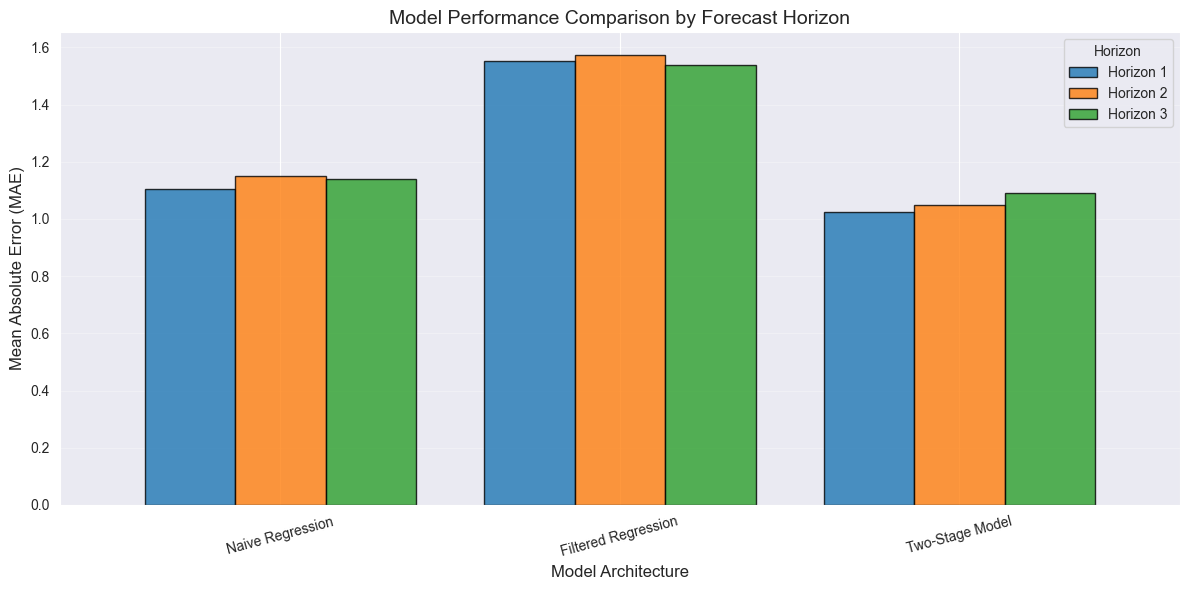

In [69]:
# Compile results
comparison = pd.DataFrame({
    'Naive Regression': [naive_results[h]['mae'] for h in [1,2,3]],
    'Filtered Regression': [filtered_results[h]['mae'] for h in [1,2,3]],
    'Two-Stage Model': [two_stage_results[h]['mae'] for h in [1,2,3]]
}, index=['Horizon 1', 'Horizon 2', 'Horizon 3'])

print("="*70)
print("MODEL COMPARISON: MEAN ABSOLUTE ERROR")
print("="*70)
print(comparison.round(3))

# Calculate improvement over naive
print("\nImprovement over Naive Baseline:")
for model in ['Filtered Regression', 'Two-Stage Model']:
    improvements = (comparison['Naive Regression'] - comparison[model]) / comparison['Naive Regression'] * 100
    print(f"\n{model}:")
    for h in [1, 2, 3]:
        print(f"  Horizon {h}: {improvements.iloc[h-1]:.1f}%")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
comparison.T.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)
ax.set_xlabel('Model Architecture', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.set_title('Model Performance Comparison by Forecast Horizon', fontsize=14)
ax.legend(title='Horizon', loc='upper right')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Walk Forward Validation

In [72]:
def walk_forward_validation(df, seasons, target_col='target_h1', window_size=5):
    """
    Simulates a real FPL season by retraining (or refitting) the model
    every 'window_size' Gameweeks.
    
    Mathematical Goal: Estimate E[L(y, f(x))] over time t.
    """
    print(f"Starting Walk-Forward Validation for {seasons}...")
    
    # 1. Setup chronological data
    # Filter for the validation seasons but keep history for training
    val_data = df[df['season'].isin(seasons)].copy()
    unique_gameweeks = val_data[['season', 'GW']].drop_duplicates().sort_values(['season', 'GW'])
    
    metrics = []
    
    # 2. Sliding Loop
    # We step through the season in blocks (e.g., every 5 GWs)
    for i in range(0, len(unique_gameweeks), window_size):
        
        # Define current 'Now' point
        if i + window_size >= len(unique_gameweeks): break
        
        current_period = unique_gameweeks.iloc[i]
        next_period = unique_gameweeks.iloc[i+window_size]
        
        current_season = current_period['season']
        current_gw = current_period['GW']
        
        print(f"  Training up to {current_season} GW {current_gw} -> Predicting next {window_size} GWs")
        
        # TEMPORAL MASKING
        # Train: All past data up to current GW
        train_mask = (df['season'] < current_season) | \
                     ((df['season'] == current_season) & (df['GW'] < current_gw))
        
        # Test: The next 'window_size' Gameweeks
        # Note: In real life, we predict 1 GW ahead, then get truth, then retrain.
        # Batching 5 GWs is a compromise for speed.
        test_mask = (df['season'] == current_season) & \
                    (df['GW'] >= current_gw) & \
                    (df['GW'] < current_gw + window_size)
        
        X_train_fold = df[train_mask][feature_cols]
        y_train_fold = df[train_mask][target_col]
        
        X_test_fold = df[test_mask][feature_cols]
        y_test_fold = df[test_mask][target_col]
        
        if len(X_test_fold) == 0: continue
            
        # 3. Train Model (Using your LightGBM parameters)
        # Note: For speed, you might reduce num_boost_round inside this loop
        model = lgb.LGBMRegressor(
            objective='regression', 
            metric='mae',
            n_estimators=100,  # Lower for loop speed
            learning_rate=0.05,
            random_state=42,
            verbosity=-1
        )
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_test_fold)
        
        # 4. Record Metrics
        fold_mae = mean_absolute_error(y_test_fold, preds)
        metrics.append({
            'season': current_season,
            'start_gw': current_gw,
            'mae': fold_mae,
            'n_samples': len(y_test_fold)
        })
        
    return pd.DataFrame(metrics)




In [73]:

df = create_targets(df)

# 2. ENCODING FIX: Convert object columns to numeric globally
# This replicates the logic from your 'prepare_features' function but applies it to the main df
if 'position' in df.columns and df['position'].dtype == 'object':
    print("Encoding 'position' column...")
    df['position'] = df['position'].map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})

if 'was_home' in df.columns and df['was_home'].dtype == 'object':
    print("Encoding 'was_home' column...")
    df['was_home'] = df['was_home'].map({True: 1, False: 0, 'True': 1, 'False': 0}).fillna(0).astype(int)

# 3. Double check for any other remaining object columns in feature_cols
# (excluding metadata like 'season' or 'name' which shouldn't be in feature_cols)
object_cols = df[feature_cols].select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print(f"WARNING: Dropping remaining object columns from features: {list(object_cols)}")
    feature_cols = [c for c in feature_cols if c not in object_cols]

# 4. Now run the validation
wf_results = walk_forward_validation(df, seasons=['2024-25'], target_col='target_h1')
print(f"Average Walk-Forward MAE: {wf_results['mae'].mean():.3f}")

Created targets for horizons: [1, 2, 3]
Final observations: 91,179
Encoding 'position' column...
Encoding 'was_home' column...
Starting Walk-Forward Validation for ['2024-25']...
  Training up to 2024-25 GW 1 -> Predicting next 5 GWs
  Training up to 2024-25 GW 6 -> Predicting next 5 GWs
  Training up to 2024-25 GW 11 -> Predicting next 5 GWs
  Training up to 2024-25 GW 16 -> Predicting next 5 GWs
Average Walk-Forward MAE: 1.113


In [74]:
def walk_forward_two_stage(df, seasons, target_col='target_h1', window_size=5):
    """
    Forensic Validation of the Two-Stage Architecture.
    Simulates the season by retraining BOTH the Classifier and Regressor
    every 'window_size' Gameweeks.
    """
    print(f"Starting Two-Stage Walk-Forward Validation for {seasons}...")
    
    # 1. Setup chronological data
    val_data = df[df['season'].isin(seasons)].copy()
    unique_gameweeks = val_data[['season', 'GW']].drop_duplicates().sort_values(['season', 'GW'])
    
    metrics = []
    
    # Define binary target column name based on the regression target
    # e.g., 'target_h1' -> 'will_play_h1'
    horizon = target_col[-1] # '1', '2', or '3'
    binary_target_col = f'will_play_h{horizon}'
    
    # 2. Sliding Loop
    for i in range(0, len(unique_gameweeks), window_size):
        
        if i + window_size >= len(unique_gameweeks): break
        
        current_period = unique_gameweeks.iloc[i]
        current_season = current_period['season']
        current_gw = current_period['GW']
        
        print(f"  Training up to {current_season} GW {current_gw}")
        
        # TEMPORAL MASKING
        train_mask = (df['season'] < current_season) | \
                     ((df['season'] == current_season) & (df['GW'] < current_gw))
        
        test_mask = (df['season'] == current_season) & \
                    (df['GW'] >= current_gw) & \
                    (df['GW'] < current_gw + window_size)
        
        # Prepare Data
        X_train = df[train_mask][feature_cols]
        y_train = df[train_mask][target_col]
        y_train_binary = df[train_mask][binary_target_col]
        
        X_test = df[test_mask][feature_cols]
        y_test = df[test_mask][target_col]
        
        if len(X_test) == 0: continue
            
        # === STAGE 1: CLASSIFIER (Will Play?) ===
        # Note: Using lower n_estimators for speed during loop
        clf = lgb.LGBMClassifier(
            objective='binary', metric='auc', n_estimators=100, 
            learning_rate=0.05, verbosity=-1, random_state=42
        )
        clf.fit(X_train, y_train_binary)
        prob_playing = clf.predict_proba(X_test)[:, 1]
        
        # === STAGE 2: REGRESSOR (Points if Playing) ===
        # Filter training data to only playing moments
        playing_mask = df[train_mask]['minutes'] > 0
        X_train_playing = X_train[playing_mask]
        y_train_playing = y_train[playing_mask]
        
        reg = lgb.LGBMRegressor(
            objective='regression', metric='mae', n_estimators=100,
            learning_rate=0.05, verbosity=-1, random_state=42
        )
        reg.fit(X_train_playing, y_train_playing)
        points_if_playing = reg.predict(X_test)
        points_if_playing = np.maximum(points_if_playing, 0) # Clip negatives
        
        # === ENSEMBLE ===
        final_preds = prob_playing * points_if_playing
        
        # Record Metrics
        fold_mae = mean_absolute_error(y_test, final_preds)
        metrics.append({
            'season': current_season,
            'start_gw': current_gw,
            'mae': fold_mae,
            'samples': len(y_test)
        })
        
    return pd.DataFrame(metrics)



In [75]:
# Run and Compare
two_stage_wf = walk_forward_two_stage(df, seasons=['2024-25'], target_col='target_h1')
print(f"Two-Stage Walk-Forward MAE: {two_stage_wf['mae'].mean():.3f}")

Starting Two-Stage Walk-Forward Validation for ['2024-25']...
  Training up to 2024-25 GW 1
  Training up to 2024-25 GW 6
  Training up to 2024-25 GW 11
  Training up to 2024-25 GW 16
Two-Stage Walk-Forward MAE: 1.021


## 9. Feature Importance Analysis (Two-Stage Model, Horizon 3)


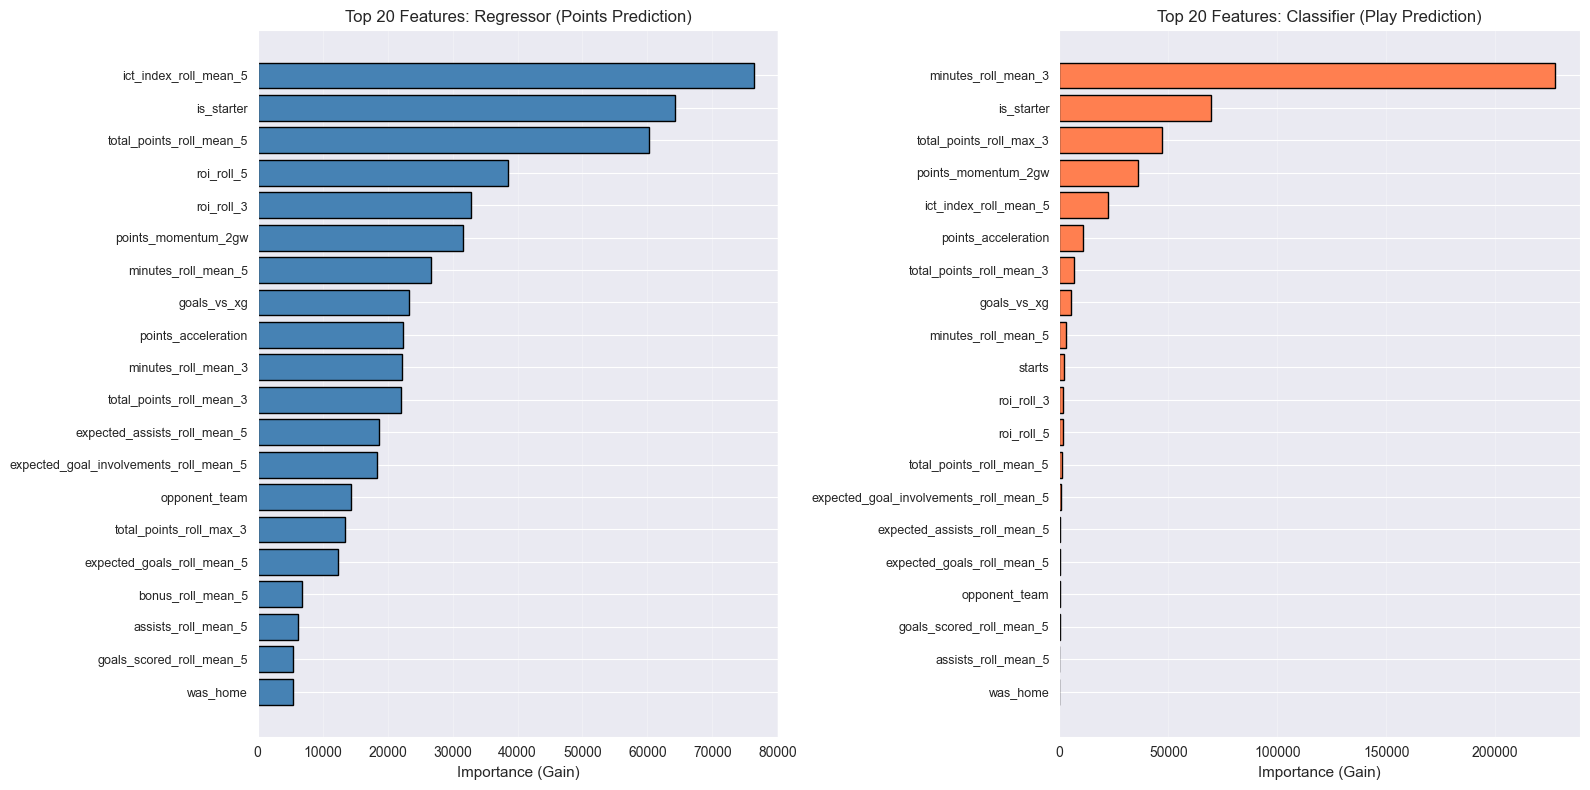


Top 10 Features (Regressor):
                 Feature  Importance_Regressor
   ict_index_roll_mean_5          76347.571869
              is_starter          64204.480541
total_points_roll_mean_5          60219.292444
              roi_roll_5          38607.674150
              roi_roll_3          32835.975134
     points_momentum_2gw          31627.925081
     minutes_roll_mean_5          26663.602890
             goals_vs_xg          23333.786152
     points_acceleration          22374.377007
     minutes_roll_mean_3          22218.181755

Top 10 Features (Classifier):
                 Feature  Importance_Classifier
     minutes_roll_mean_3          227585.202709
              is_starter           69731.655632
 total_points_roll_max_3           47064.275186
     points_momentum_2gw           36161.742548
   ict_index_roll_mean_5           22359.223505
     points_acceleration           10884.706093
total_points_roll_mean_3            6855.788115
             goals_vs_xg            54

In [71]:
# Get feature importance from best model (Horizon 3, Two-Stage)
importance_reg = two_stage_results[1]['regressor'].feature_importance(importance_type='gain')
importance_clf = two_stage_results[1]['classifier'].feature_importance(importance_type='gain')

# Create DataFrames
feature_names = [feature_cols[i] for i in range(len(feature_cols))]
importance_df_reg = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Regressor': importance_reg
}).sort_values('Importance_Regressor', ascending=False)

importance_df_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Classifier': importance_clf
}).sort_values('Importance_Classifier', ascending=False)

# Plot top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Regressor importance
top20_reg = importance_df_reg.head(20)
axes[0].barh(range(20), top20_reg['Importance_Regressor'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top20_reg['Feature'], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance (Gain)', fontsize=11)
axes[0].set_title('Top 20 Features: Regressor (Points Prediction)', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Classifier importance
top20_clf = importance_df_clf.head(20)
axes[1].barh(range(20), top20_clf['Importance_Classifier'], color='coral', edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top20_clf['Feature'], fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance (Gain)', fontsize=11)
axes[1].set_title('Top 20 Features: Classifier (Play Prediction)', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Features (Regressor):")
print(importance_df_reg.head(10).to_string(index=False))

print("\nTop 10 Features (Classifier):")
print(importance_df_clf.head(10).to_string(index=False))